In [1]:
%load_ext autoreload
%autoreload 2

import torch
import numpy as np 
import matplotlib.pyplot as plt
from IPython import display
import glob
import scipy

from src.mat_dataset import MAT_Dataset,EVAL_Dateset
from torch.utils.data import DataLoader
from torchsummary import summary
from src.models import Beam_DnCNN_3D, train_model

from src.metrics import complex_MSE
import json

In [3]:
def gen_noise(H, SNR):
    N_tti, N_ue_ant, N_bs, N_subc = H.shape[0], H.shape[1],H.shape[2], H.shape[3]
    noise_SRS = torch.sqrt(0.5) * (torch.rand(N_tti, N_ue_ant, N_bs, N_subc) + 1j*torch.rand(N_tti, N_ue_ant, N_bs, N_subc))
    gain = torch.sqrt(torch.mean(H * H.conj(), dim = -1).unsqueeze(-1).repeat(1,1,1,288))
    noise_SRS_normed = 10**(-SNR/20) * gain * noise_SRS
    return noise_SRS_normed


In [ ]:
# def gen_noise(H, SNR):
#     # H in 288 64 16 80
#     N_tti, N_ue_ant, N_bs, N_subc = H.shape[0], H.shape[1],H.shape[2], H.shape[3]
#     noise_SRS = torch.sqrt(0.5) * (torch.rand(288,64,16,80) + 1j*torch.rand(288,64,16,80))
#     gain = torch.sqrt(torch.mean(H * H.conj(), dim = 0).unsqueeze(0).repeat(288,1,1,1))
#     noise_SRS_normed = 10**(-SNR/20) * gain * noise_SRS
#     return noise_SRS_normed


In [4]:
file_list = glob.glob('./data/*.mat')
train_dataset = MAT_Dataset(file_list[0], [0,1,2])
test_dataset = MAT_Dataset(file_list[0], [3])

batch_size = 2
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = True)


In [3]:
# cfg = json.load(open("model_config.txt"))

# model = Beam_DnCNN_3D(cfg = cfg)
# x = next(iter(train_loader))

# y = model.WindowCut(
#     model.complex_to_dim(
#     model.left_transform(x, norma = torch.tensor([0.1, 0.1]))
#     ))

# x_ = model.right_transform(
#      model.dim_to_complex(
#      model.WindowCut(y, 'backward')))

# print(torch.sum(abs(x - x_)**2))
# print(torch.sum(abs(x)**2))

# x_denoised, noise_pred, L1 = model(x, torch.tensor([0.1, 0.1]))

/Users/albly/GitHub/Deep_learning_MIMO_channel_denoise/src/models.py:67: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data, a = 0, mode='fan_in')


tensor(7.8490e-09)
tensor(313344.)


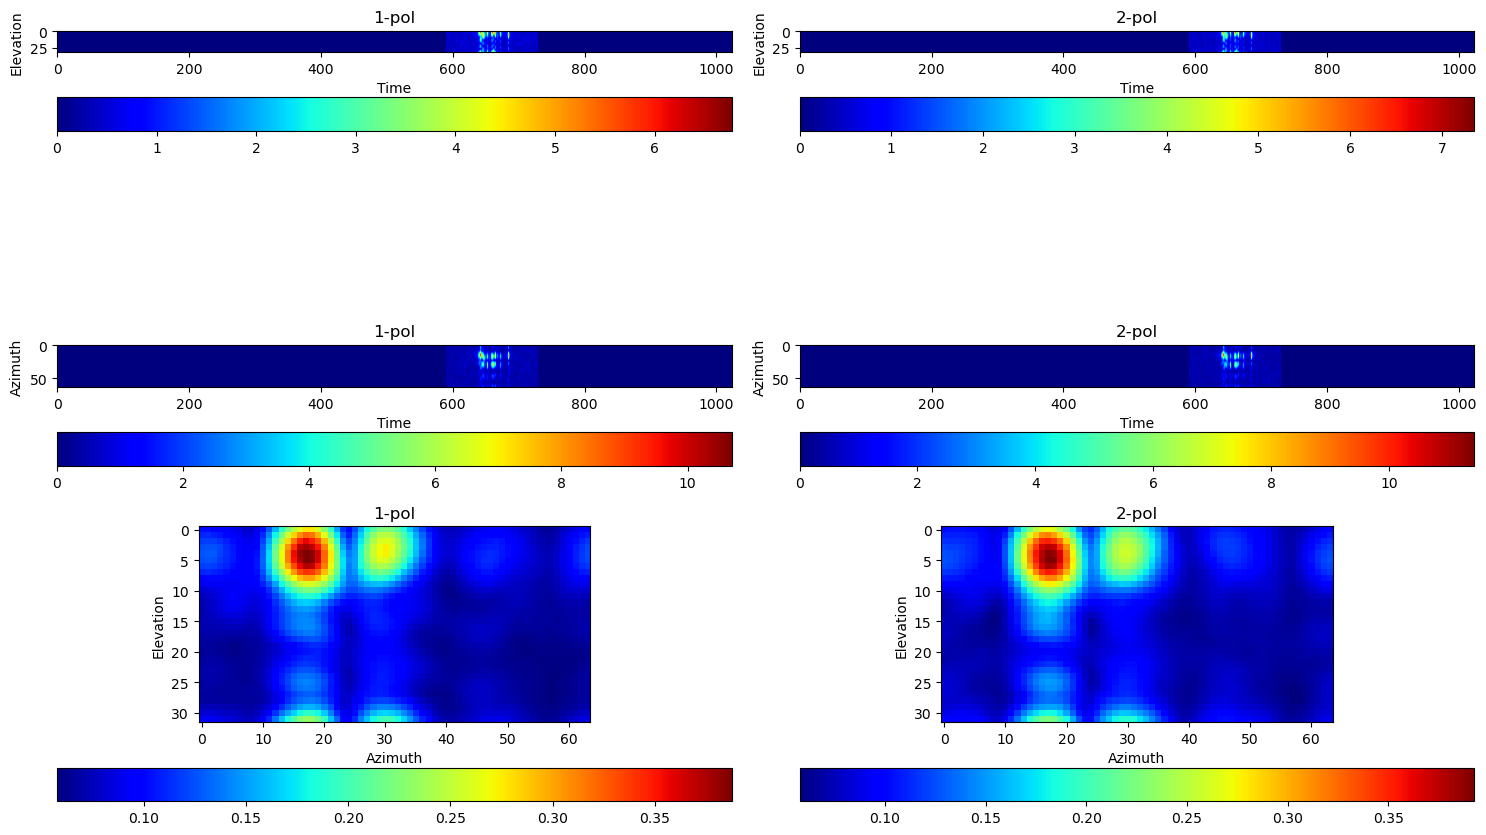

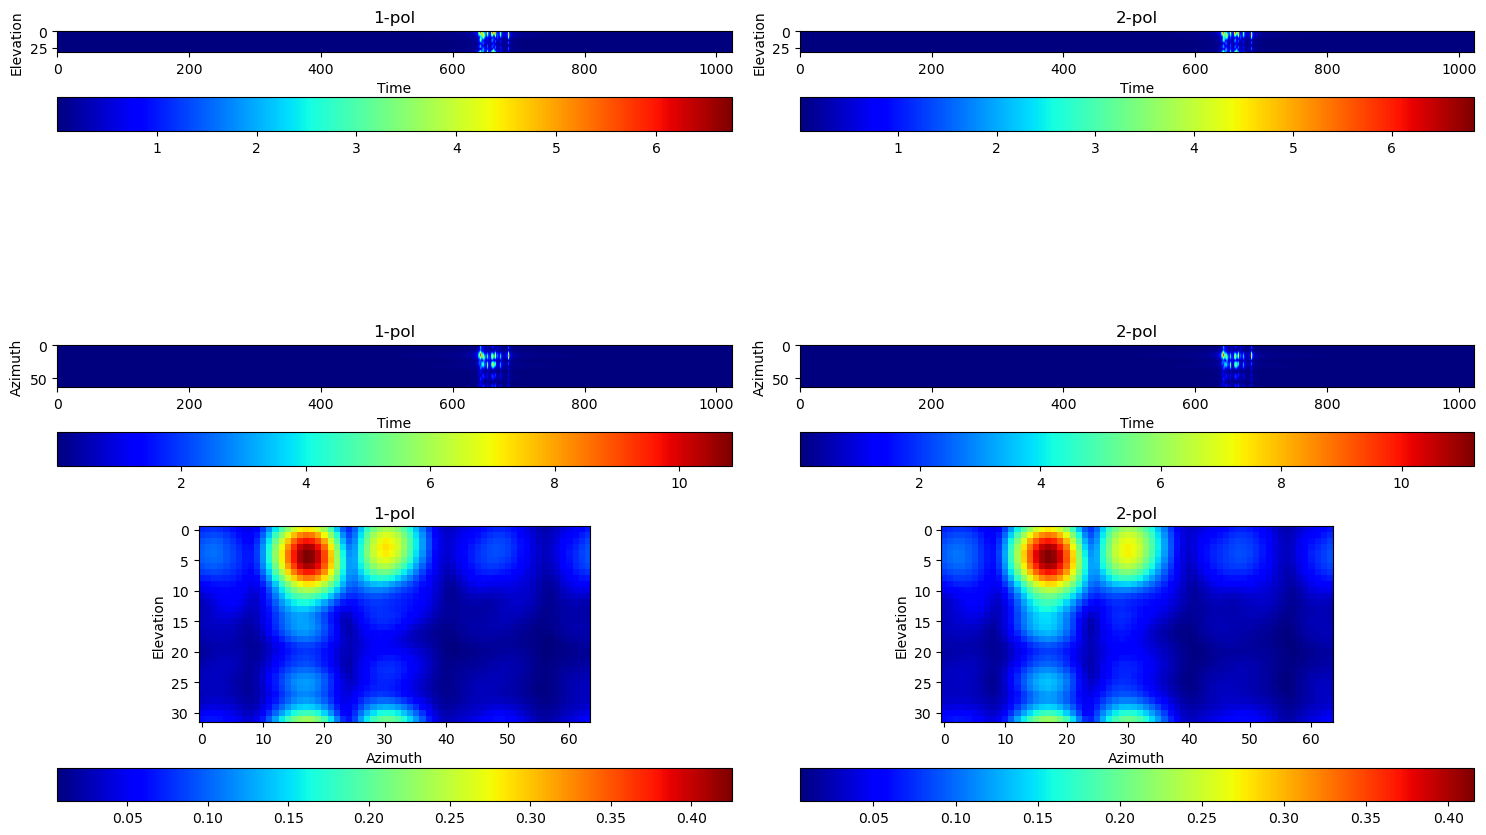

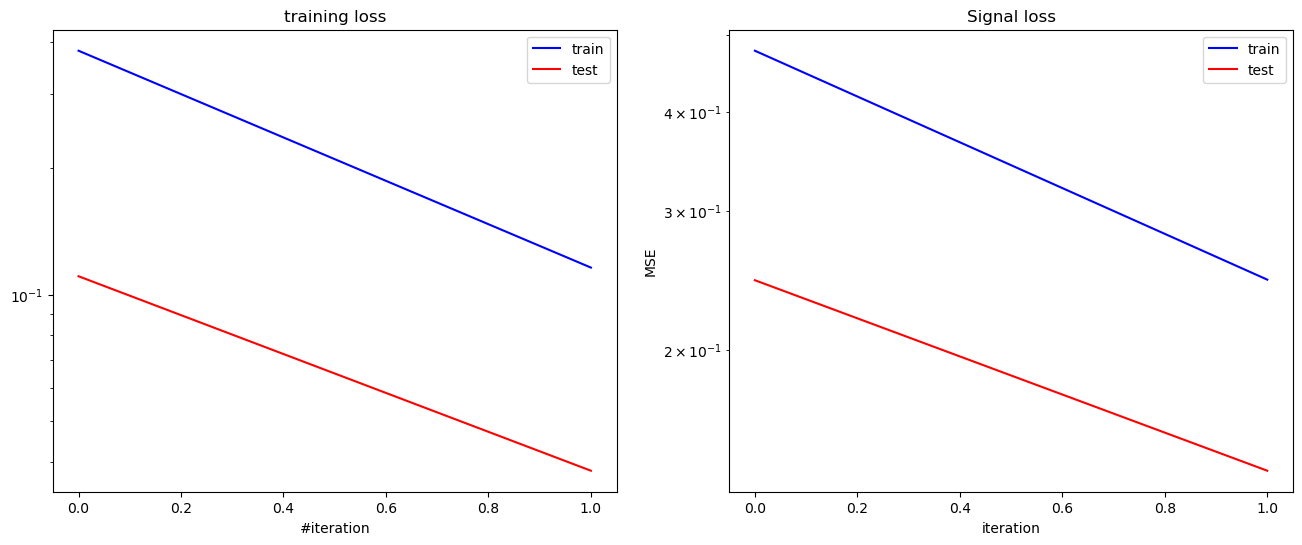

KeyboardInterrupt: 

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

#=======================================================================
cfg = json.load(open("model_config.txt"))
#=======================================================================

model = Beam_DnCNN_3D(cfg = cfg, n_layers = 15, n_features = 20)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones = [150, 200, 250], gamma = 0.1)

train_model(model = model,
            cfg = cfg,
            epochs = 200,
            trainLoader = train_loader,
            testLoader = test_loader,
            optimizer = optimizer,
            scheduler = scheduler,
            criterion = complex_MSE,
            SNR = -10)